# ImageAnnotationChallenge

## Overview : 概要

### Project target : プロジェクト目標

- 普通のECサイトにおける検索機能について､改善方法を検討する
- 画像認識によるタグ付けの開発を優先する
- メンバーも実際のプロジェクト経験をもらいつつ､デモプロジェクトの開発と記事を作成できるまで頑張る

In English:
- Consider the ways how to improve search function on e-commerce site.
- Prioritize the development of tagging by image recognition.
- The members will do our best until creating an article and developing demo project, gaining project experience.


### Study scope : 学習範囲

* Note記事を書く
* 画像認識によるタグ付けを優先して開発する
* 日本語･英語両方タグ付けできるようにする

In English:

* Write a note article
* Develop tagging system by image recognition in priority
* The system becomes able to tag  in Japanese and English


### Repository

* [TOP](https://github.com/ryu-i-engineer/ImageAnnotationChallenge)
* [Projects](https://github.com/ryu-i-engineer/ImageAnnotationChallenge/projects/2)

## Reference

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/segmentation

### About Transfer learning

#### Domain problem

- [転移学習：機械学習の次のフロンティアへの招待](https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%81%AE%E5%8F%96%E3%82%8A%E7%B5%84%E3%82%80%E5%95%8F%E9%A1%8C)

## Dataset

### Using web scraping

- https://jp.misumi-ec.com/vona2/mech_screw/M3303000000/?rid=c21_top_4_M3303000000
- https://www.ipros.jp/product/
- https://ecclab.empowershop.co.jp/archives/2536

### Fasteners : ネジ･ボルト･座金･ナット

#### Hand tools for screws : ネジ用工具

#### Hair pins & Cotter pins : スナップピン･割りピン

#### Inserts : インサート

- Tangless inserts : タングレスインサート
- Threaded inserts : ネジインサート
- Tools for Tangless inserts : タングレスインサート専用工具
- Tools for threaded inserts : ネジインサート用工具

#### Machine keys : マシンキー

#### Nuts : ナット

- Cylindrical nuts: 丸ナット
- Domed & Acorn nuts : 袋ナット
- Flanged nuts : フランジ付きナット
- Hex nuts : 六角ナット
- High nuts(Spacers) : 高ナット(スペーサー)
- Knurled nuts : ローレットナット
- Lock nuts : ロックナット･ゆるみ止めナット
- Non-metal nuts : 樹脂ナット
- Rectangular & Square nuts : 四角ナット
- Wing nuts : 蝶ナット
- Rivet nuts : リベットナット
- Weld nuts : ウェルドナット(溶接ナット)
- Clinching nuts : クリンチングナット
- Clip nuts :クリップナット
- Cap nuts : キャップナット
- Washer based nuts : 歯付き座金ナット･溝付き六角ナット
- Gauge nuts : ゲージナット

#### Retaining rings : 止め輪･リング

#### Screws & Bolts : ネジ･ボルト

- Captive Washer Screws : 座金組み込みネジ
- Cross Recessed Bolts : 低頭ボルト
- Eye Screws, Eye Bolts & Eye Nuts : アイボルト･でんでんボルト
- Fastener Accessories : ネジ用アクセサリー
- Fully-Threaded Bolts & Stud Bolts : 全ねじ･スタッドボルト
- Hex Bolts : 六角ボルト
- Hex socket button head cap screws : 六角穴付ボタンボルト
- Hex socket flat head cap screws : 六角穴付皿ボルト
- Hex socket head cap screw: 六角穴付ボルト
- Micro Screws & Precision screws : マイクロネジ･微細ネジ
- Plastic & Ceramic screws : 樹脂ネジ･セラミックネジ
- Self tapping screws : タッピングネジ･タップタイト･ハイテクネジ
- Set screws : 止めネジ
- Small head bolts : 小径ボルト
- Space Saving bolts : 低頭ボルト
- Strippers, Reamers & Shoulder bolts : ストリッパー･リーマ･ショルダーボルト
- Tamper Resistant screws : いたずら防止ネジ
- Vented Screws : 貫通穴付ボルト
- Wing, Thumb & Ornamental screws : 蝶ボルト･つまみネジ･化粧ビス

#### Screw plug hardware : スクリュープラグ

#### Shims : シム

- Rectangular shims : 角シム
- Shim plates : シムプレート
- Shim rings : シムリング
- Shim tape : シムテープ

#### Wahers : 座金(ネジ用ワッシャ)

- Metal washers : 金属ワッシャ
- Non-metal washers & Collars : 非金属･樹脂ワッシャ

### Wiring components : 配線部品

#### LAN & Industrial Network cables : LAN･産業用ネットワークケーブル

- LAN cable : LANケーブル(コネクタ付)
- LAN / Network cable : LAN･省配線ネットワークケーブル(ケーブル単体)
- Fiber Optic cable accessories : 光ファイバケーブル(オプションその他)
- LAN cable & connector accessories : LANケーブル･コネクタオプション
- Network cable adapters : LAN中継･延長用アダプタ
- Network cable connectors : LANコネクタ
- Telephone cable : 電話線(RJ11)
- Fiber optic cable : 光ファイバケーブル


#### Equipment specific cables : 機器対応ケーブル

- AC servo motor cables : ACサーボモータ用ケーブル
- Cordset Accessories : ハーネス(オプション)
- I/O board cables : I/Oボード対応ケーブル
- Image sensor cables : 画像センサ対応ケーブル
- PLC cables : PLC対応ケーブル
- Relay terminal cables : リレーターミナル対応ケーブル
- Sensor cordsets : センサ対応ケーブル
- Single Axis Robot cables : 単体ロボットケーブル
- Stepper motor cables : ステッピングモータ用ケーブル
- Touch panel cables : タッチパネル対応ケーブル
- Solenoid valve compatible cable : 電磁弁対応ケーブル

#### Cordsets : コネクタ付ケーブル(汎用)

- Circular cordsets : 丸形コネクタ付ケーブル
- Coaxial cordsets : 
- Conversion & branching cordsets : 変換･分岐ケーブル
- Nylon connector cordsets : ナイロンコネクタ付ケーブル
- Square cordsets : 角型コネクタ付ケーブル

#### Cable accessories : ケーブルアクセサリー

- Cable Accessories : ケーブルアクセサリー
- Conductive tape : 導電性テープ
- Electrical tape : テープ･シール

#### Cable gland components : ケーブルグランド

#### Cable bushings, Clip & stickers : ケーブルブッシュ･クリップ･ステッカー


- Cable bushings: ケーブルブッシュ
- Cable clips : ケーブルクリップ
- Cable stickers : ケーブルステッカー

#### Cable organization : 結束バンド

- Cable ties : 結束バンド
- Cable tie mounts & accessories : 結束バンド固定具･オプション

#### Computer & AV cables : RS232･パソコン･AVケーブル(OA機器対応)

- Audio Video cable components : AVケーブル
- Display cable components : ディスプレイケーブル
- Printer cable components : プリンタケーブル
- PS/2 Cable components : PS/2規格ケーブル
- RS232C cables : RS232Cケーブル
- SCSI cable components : SCSIケーブル
- USB cable supplies : USBケーブル
- Antenna cable : アンテナケーブル

#### Crimp terminal components : 圧着端子

- Crimp terminals : 圧着端子
- Crimp terminal accessories : 圧着端子(オプション･その他)

#### Electrical conduits : 保護管

- Metal conduits : 金属管
- Metal conduit accessories : 金属管オプション
- Plastic conduits : 樹脂管
- Plastic conduits accessories : 樹脂管オプション

#### Electrical Tubing & sleeving : チューブ

- Braided sleeves : 編組チューブ
- Cable sleeving : シート型チューブ
- Electrical tubing accessories : チューブオプション
- General Purpose tubing : 汎用チューブ
- Heat shrink tubing : 熱収縮チューブ
- Spiral wraps : スパイラルチューブ

#### Electrical wiring tools : 汎用工具

- Cable tie tools : 結束工具
- Crimping & IDC tools : 圧着工具･圧接工具
- Electrical wiring tool accessories : 汎用工具(オプション･その他)
- Wire cutting tools : 切断工具
- Wiring connection screwdrivers : ドライバー(配線接続用)
- Wiring tweezers & wranches : ピンセット･レンチ
- Wiring stripper tools : 電線剥き工具

#### Screw & spacer components

#### Soldering supplies

- Soldering tools : ハンダ付け工具
- Soldering iron holders : ハンダごてホルダー

#### Specialized wiring tools : 専用工具

- Connector tools : コネクタ専用工具
- Specialized wiring tool accessories : 専用工具(オプション･その他)
- Terminal removal tools : 端子引抜工具

#### Wire & Cable

- Coaxial cables: 同軸ケーブル
- Coiled cords : カールコード
- Control & Instrumentation cables : 制御･計装ケーブル
- Environmentally friendly cables : エコ電線ケーブル
- Flexible robot cables : ロボットケーブル
- Hook-Up wires : 電気･電子･通信機器用絶縁電線
- Power cables : 電力ケーブル
- Ribbon cables : フラットケーブル
- Information communication cable : 情報通信ケーブル
- Wire storage : 電線収納具
- Disaster prevention alarm cable : 防災用警報用ケーブル
- LAN / Network cable : LAN･省配線ネットワークケーブル(ケーブル単体)

#### Wiring connectors : コネクタ

- Cicular connectors : 丸形コネクタ
- Coaxial connectors : 同軸コネクタ
- Connector accessories : コネクタ(オプション･その他)
- Connector Adapters : 変換コネクタ
- Connector caps : コネクタ用キャップ
- Connector sets : コネクタセット
- Contacts & Pins : コンタクトピン
- Nylon connectors : ナイロンコネクタ
- Rectangular connectors : 角型コネクタ


#### Wire ducts & cable raceways

- Cable raceways : モール
- Cable raceway accessories : モールオプション
- Wire ducts : ワイヤダクト
- Wire duct accessories : ワイヤダクトオプション

### Dummy data

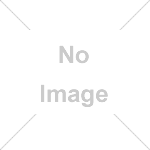
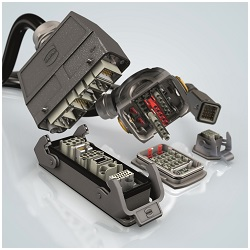

## Codes

### Try TensorFlow tutorial

### Using TF Hub for Transfer learning

#### Prepare

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15320582120477015702
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5688774635448553162
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
import tensorflow_hub as hub

In [5]:
# Download classification
# classifier_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5" # ResNet-152
# classifier_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2" # EfficientNet V2

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

# classifier_model = mobilenet_v2

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE+(3,))
])

#### Execute one image file

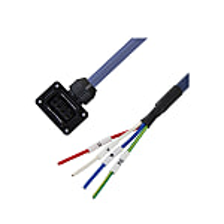

In [7]:
import numpy as np
import PIL.Image as Image

# grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
# grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = Image.open("./inputs/misumi_dataset/ac_servo_motor_cables/000001.jpg").resize(IMAGE_SHAPE)
grace_hopper

In [8]:
# Get batch dimension and input image to model.
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [9]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=793>

#### Decode the predict result

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

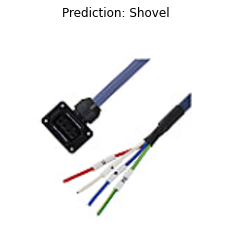

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [13]:
# data_root = tf.keras.utils.get_file(
#   'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)

data_root = "./inputs/misumi_dataset_cleansing"

In [14]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 12205 files belonging to 136 classes.
Using 9764 files for training.
Found 12205 files belonging to 136 classes.
Using 2441 files for validation.


In [15]:
class_names = np.array(train_ds.class_names)
print(f"This datasets has {len(class_names)} classes.")

This datasets has 136 classes.


In [16]:
# add normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [17]:
# avoid I/O blocking issues
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


#### Download headless model

In [19]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
effienct_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

feature_extractor_model = effienct_v2

In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

# feature_extractor_layer = hub.KerasLayer(
#     feature_extractor_model,
#     input_shape=(224, 224, 3),
#     trainable=True
# )

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


#### Attach a classification head

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

In [23]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 136])

#### Train model

In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 136)               174216    
Total params: 6,093,528
Trainable params: 174,216
Non-trainable params: 5,919,312
_________________________________________________________________


In [25]:
NUM_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc', min_delta=0.0001, patience=1
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/50
306/306 [==============================] - 91s 282ms/step - loss: 2.1335 - acc: 0.5060 - val_loss: 1.4414 - val_acc: 0.6313
Epoch 2/50
306/306 [==============================] - 29s 95ms/step - loss: 1.1492 - acc: 0.7059 - val_loss: 1.1673 - val_acc: 0.6985
Epoch 3/50
306/306 [==============================] - 28s 93ms/step - loss: 0.8831 - acc: 0.7678 - val_loss: 1.0547 - val_acc: 0.7157
Epoch 4/50
306/306 [==============================] - 28s 92ms/step - loss: 0.7301 - acc: 0.8066 - val_loss: 0.9941 - val_acc: 0.7317
Epoch 5/50
306/306 [==============================] - 28s 92ms/step - loss: 0.6249 - acc: 0.8360 - val_loss: 0.9574 - val_acc: 0.7440
Epoch 6/50
306/306 [==============================] - 28s 93ms/step - loss: 0.5462 - acc: 0.8578 - val_loss: 0.9343 - val_acc: 0.7476
Epoch 7/50
306/306 [==============================] - 29s 93ms/step - loss: 0.4844 - acc: 0.8733 - val_loss: 0.9192 - val_acc: 0.7489
Epoch 8/50
306/306 [==============================] - 29s 93m

In [26]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['wiring_connector_caps' 'wiring_rectangular_connectors'
 'wiring_rectangular_connectors' 'wiring_lan_network_cable'
 'wiring_connector_circular' 'wireDucts_ducts' 'cableBushing_stickers'
 'wiring_coaxial' 'washers_metal' 'wiring_rectangular_connectors'
 'wiring_connector_circular' 'cableBushing_clips' 'comAV_usb'
 'wiring_rectangular_connectors' 'washers_non-metal_and_collars'
 'crimp_terminals' 'wiring_connector_circular'
 'wireDucts_ducts_accessories' 'wiring_connector_caps'
 'wiring_connector_circular' 'braided_sleeves' 'wiring_connector_circular'
 'wiring_rectangular_connectors' 'crimp_terminals'
 'wiring_connector_coaxial' 'wiring_nylon_connectors' 'crimp_terminals'
 'wiring_rectangular_connectors' 'cable_sleeving' 'nuts_hex'
 'cordsets_square' 'heat_shrink_tubing']


#### Visualization of model training history

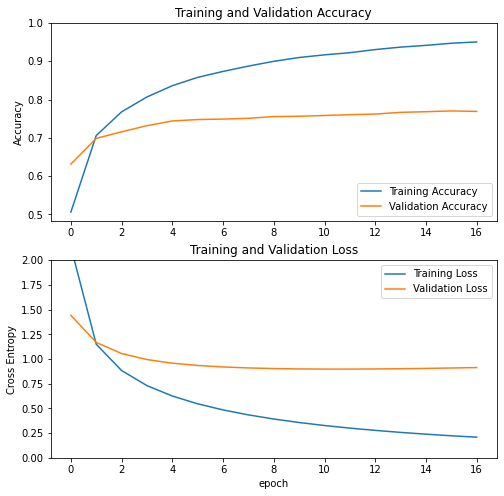

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Try fine tuning

In [28]:
model.trainable = True

In [29]:
print("Number of layers in the model: ", len(model.layers))

Number of layers in the model:  2


#### Result

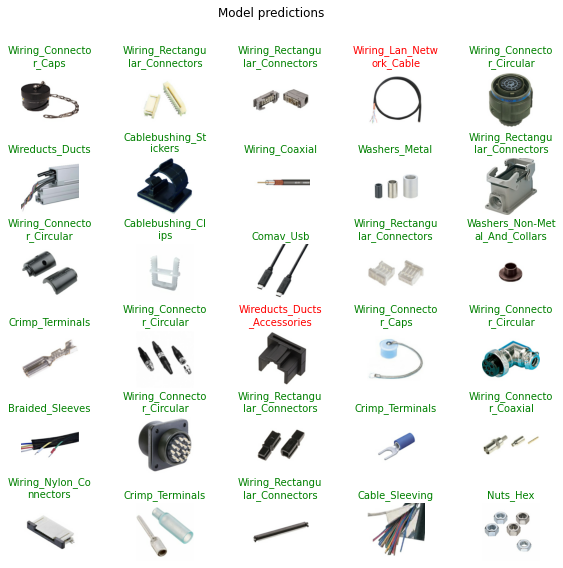

In [30]:
from textwrap import wrap
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n].numpy() == labels_batch[n].numpy() else "red"
  plt.title('\n'.join(wrap(predicted_label_batch[n].title(), 15)), color=color, fontsize=10)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Export model

In [31]:
# from datetime import date

# export_path = f"./models/{date.today().isoformat()}_2"
# model.save(export_path, save_format='tf')

# export_path

In [32]:
# import os
# # os.listdir("./models/")
# print(len(next(os.walk('./models/'))[1]))

In [33]:
# reloaded = tf.keras.models.load_model(export_path)

In [34]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [35]:
# abs(reloaded_result_batch - result_batch).max()